In [1]:
import json
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta, time
from tqdm.notebook import tqdm
import networkx as nx
from collections import defaultdict
import pickle
from shapely.geometry import Point,LineString, Polygon, shape
from copy import deepcopy
import os
from itertools import combinations
import math
from itertools import cycle

# Technical functions

In [2]:
def get_date_range(month_start, year_start, month_end, year_end):
    month_range = list(range(1,13))
    cycle_month_range = cycle(month_range)
    while True:
        current_month = next(cycle_month_range)
        if current_month == month_start:
            break
    date_tuples = []
    year = year_start
    while True:
        if current_month < 10:
            date_tuples.append(("0"+str(current_month), str(year)))
        else:
            date_tuples.append((str(current_month), str(year)))
        if year == year_end and current_month == month_end:
            break
        current_month = next(cycle_month_range)
        if current_month == 1:
            year += 1
    return date_tuples


def upload_schedule(in_file):
    def date_hook(json_dict):
        for (key, value) in json_dict.items():
            for index_list_entry in range(len(value)):
                for index_entry, v in enumerate(value[index_list_entry]):
                    try:
                        json_dict[key][index_list_entry][index_entry] = datetime.strptime(
                            v, "%Y-%m-%d %H:%M:%S"
                        )
                    except:
                        pass
        return json_dict

    with open(in_file, "r") as in_f:
        return json.load(in_f, object_hook=date_hook) # output: dict 


def _distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6372.8  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Import railroad tracks as LineStrings

Import file with all LineStrings of railroad tracks taken from supplementary Infrabel data: https://infrabel.opendatasoft.com/explore/dataset/lijnsecties/information/. This dataframe contains a lot of useless technical information that we disregard. Also it contains nan values, which we drop.

In [29]:
supplemetary_dir = "./supplementary_data/"
segmentatie_path = os.path.join(
    supplemetary_dir,
    "segmentatie-volgens-de-eigenschappen-van-de-infrastructuur-en-de-exploitatiemoge.geojson"
)
segmentatie_df = gp.read_file(segmentatie_path)

segmentatie_geo_df = segmentatie_df.drop(
    columns = [
        'ptcarfromname', 'nrtracks', 'symnamefrom', 'gauge_nat', 'c70', 
        'ecs_maxtraincurrent', 'symnameto', 'mfrom', 'ptcarto', 'c400', 
        'p70', 'linecat_f', 'ecs_voltfreq', 'linecat_p', 'p400', 'ptcartoname', 
        'ls_id', 'mto', 'gauge', 'ptcarfrom', 'ecs_minwireheight', 
        'ecs_maxstandstillcurrent'
    ]
)
segment_bounds = segmentatie_geo_df.bounds 
none_index_list = list(segment_bounds[segment_bounds['minx'].isnull()].index)
segmentatie_geo_df.drop(index = none_index_list, inplace = True)
segmentatie_nona_df = segmentatie_geo_df.dropna()
segmentatie_geo_df = segmentatie_nona_df.to_crs({'init': 'epsg:4326'})


/Users/amedvede/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
segmentatie_geo_df.head()

,label,geometry
0,211(2),"LINESTRING (4.23492 51.29192, 4.23470 51.29187..."
1,37,"LINESTRING (6.04749 50.70253, 6.04659 50.70450..."
2,52/2,"LINESTRING (4.34055 51.06828, 4.34058 51.06825..."
3,165/2,"LINESTRING (5.82214 49.55364, 5.82214 49.55364..."
4,25,"LINESTRING (4.49084 51.03650, 4.49086 51.03663..."


# Build the preliminary network

We have node coordinates from the previous step. We match them with the linestrings of railroad tracks. Two linestring segments are connected together, if their ending points are close.

In [31]:
intermediate_data_dir = "./intermediate_data/"
nodes_with_coordinates_filepath = os.path.join(
    intermediate_data_dir, "remaining_nodes_with_coordinates.pkl"
)
node_positions = pickle.load(open(nodes_with_coordinates_filepath, "rb"))

In [61]:
NG = nx.Graph()
for u, coords in node_positions.items():
    NG.add_node(u, lon = coords[0], lat = coords[1])
print(nx.info(NG))

node_proximity_threshold = 0.1
def get_dist_point_to_NG_nodes(point_coords, NG):
    return [(_distance(point_coords, (dd["lon"], dd["lat"])), u) for u, dd in NG.nodes(data = True)]

junction_index = 0
for index, row in tqdm(segmentatie_df.iterrows(), total = len(segmentatie_df)):
    if row["geometry"] is None:
        continue

    line = row["geometry"]
    line_coords = list(line.coords)

    e1_dist, e1 = min(get_dist_point_to_NG_nodes(line_coords[0], NG), key = lambda x: x[0])
    if e1_dist < node_proximity_threshold:
        current_node = e1
    else:
        NG.add_node(junction_index, lon = line_coords[0][0], lat = line_coords[0][1])
        current_node = junction_index
        junction_index += 1
    if len(line_coords) > 2:
        for p in line_coords[1:-1]:
            u_dist, u = min(get_dist_point_to_NG_nodes(p, NG), key = lambda x: x[0])
            if u_dist < node_proximity_threshold:
                if u != current_node:
                    if not NG.has_edge(current_node, u):
                        NG.add_edge(current_node, u)
                    current_node = u
    e2_dist, e2 = min(get_dist_point_to_NG_nodes(line_coords[-1], NG))
    if e2_dist > node_proximity_threshold:
        NG.add_node(junction_index, lon = line_coords[-1][0], lat = line_coords[-1][1])
        if not NG.has_edge(current_node, junction_index):
            NG.add_edge(current_node, junction_index)
        junction_index += 1
    else:
        if not NG.has_edge(current_node, e2):
            NG.add_edge(current_node, e2)
        current_node = e2
    
print(nx.info(NG))

Graph with 580 nodes and 0 edges


  0%|          | 0/1025 [00:00<?, ?it/s]

Graph with 1028 nodes and 1504 edges


### Save the intermediate network

In [33]:
supplemetary_dir = "./supplementary_data/"
out_network_file = "./network_from_segmentatie_v1.pkl"
out_network_path = os.path.join(supplemetary_dir, out_network_file)
pickle.dump(NG, open(out_network_path, "wb"))

In [34]:
# Just a line of code to load an existing network
NG = pickle.load(open(out_network_path, "rb"))

# Manual changes 

After manual visual check, we notice that some stations are not identified correctly. We perform necessary alterations.

### Position of Chaudfontaine

Change it because it was wrongly placed on the map.

In [35]:
NG.nodes["CHAUDFONTAINE"]["lon"] = 5.643913
NG.nodes["CHAUDFONTAINE"]["lat"] = 50.586960

### Get rid of a bunch of stations near Antwerpen Haven, no use from them, they are junctions

In [36]:
NGpos = {u: (dd["lon"], dd["lat"]) for u, dd in NG.nodes(data = True)}
antwerpen_integer_stations = [u for u, (x,y) in NGpos.items() if 4.2<x<4.42 and 51.225<y< 51.38] + [106, 293]
NG.remove_nodes_from(antwerpen_integer_stations)

### Get rid of a bunch of SCHAARBEEK stations 

In [37]:
## True schaarbeek remove stations
schaarbeek_integer_stations = [u for u, (x,y) in NGpos.items() if (4.37343<x<4.41743 and 
                                                                   50.87369<y<50.9176 and isinstance(u, int))] 
NG.remove_nodes_from(schaarbeek_integer_stations)
NG.add_edge("SCHAARBEEK", 181)
NG.add_edge("SCHAARBEEK", 309)
NG.add_edge("SCHAARBEEK", "BUDA") 
NG.add_edge("SCHAARBEEK", "HAREN-ZUID") 

### Extra edge between Brussels Luxembourg and Etterbeek


In [38]:
NG.remove_edge("BRUSSEL-LUXEMBURG", "ETTERBEEK")

### Inconsistency in shortest path detection between Brussels-Schuman and Brussels-North stations

In [39]:
NG.remove_node(314)
NG.remove_edge(40, 58)
NG.add_edge("BRUSSEL-SCHUMAN", 40)
NG.add_edge("BRUSSEL-NOORD", 40 )

### Multiple shortest paths between Brussels-North and Bockstael

In [40]:
NG.add_edge("BRUSSEL-NOORD", 171)

### Complex place neat Gent-dampoort, exclude extra one-track path

In [41]:
NG.remove_nodes_from([148, 287, 218])
NG.add_edge('GENT-DAMPOORT', 60)

### Connect the remaining stations manually, either to the closest ones or assign the station to the integral nodes

In [42]:
out_of_data_stations_relabel = {90 : 'OUGREE', 140: "BAULERS"}
nx.relabel_nodes(NG, out_of_data_stations_relabel, copy = False)
out_of_data_stations_insert = {'CHAUDFONTAINE': ('TROOZ', 'CHENEE')}
for u, value in out_of_data_stations_insert.items():
    v,w = value
    NG.remove_edge(v,w)
    NG.add_edge(u,v)
    NG.add_edge(u,w)

### Complicated place near Lier

In [43]:
NG.remove_node(14)
NG.add_edge("LIER", 13)
NG.remove_node(268)
NG.add_edge(13,"DUFFEL" )

### Complicated place near ARCADEN - Delta - Etterbeek

In [44]:
NG.remove_nodes_from([405,319,35])
NG.add_edge("ETTERBEEK", "ARCADEN")
NG.add_edge("DELTA", "ARCADEN")
NG.add_edge("ETTERBEEK", "DELTA")
NG.add_edge("WATERMAAL", "DELTA")
NG.add_edge('LISSEWEGE', 'BRUGGE-SINT-PIETERS')

### Delete nodes without disturbing the connectivity

In [45]:
nodes_to_delete = ["HASSELT-AFLOS L.35", "MACHELEN", "LUCHTBAL-WIJKBUNDEL", "BAULERS"]
for u in nodes_to_delete:
    u_neighbors = list(NG.neighbors(u))
    for u1, u2 in combinations(u_neighbors, 2):
        NG.add_edge(u1,u2)
    NG.remove_node(u)

### Get rid of hanging ends of junstion stations

In [46]:
while True:
    non_stations = [u for u, dd in NG.nodes(data = True) 
                    if isinstance(u, int)]
    neighbors_non_stations = []
    for u in non_stations:
        neighbors_non_stations.append(len(list(NG.neighbors(u))))
    print(f"Min neighbors degree {min(neighbors_non_stations)}, max neighbors degree {max(neighbors_non_stations)}")
    if min(neighbors_non_stations) > 1: break
    for u in tqdm(non_stations):
        neighbors = list(NG.neighbors(u))
        if len(neighbors) < 2:
            NG.remove_node(u)
print(f"Number connected components : {nx.number_connected_components(NG)}")


Min neighbors degree 0, max neighbors degree 6


  0%|          | 0/336 [00:00<?, ?it/s]

Min neighbors degree 0, max neighbors degree 6


  0%|          | 0/268 [00:00<?, ?it/s]

Min neighbors degree 1, max neighbors degree 6


  0%|          | 0/255 [00:00<?, ?it/s]

Min neighbors degree 1, max neighbors degree 6


  0%|          | 0/253 [00:00<?, ?it/s]

Min neighbors degree 2, max neighbors degree 6
Number connected components : 3


# Save the network

In [47]:
out_network_dir = "./final_network"
os.makedirs(out_network_dir, exist_ok = True)
full_network_path = os.path.join(
    out_network_dir, 
    "network_Belgium_full.graphml"
)
nx.write_graphml(NG, full_network_path)

## Plot the network for inspection

In [26]:
full_network_path = os.path.join(
    out_network_dir, 
    "network_Belgium_full.graphml"
)
NG = nx.read_graphml(full_network_path)

/Users/amedvede/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None



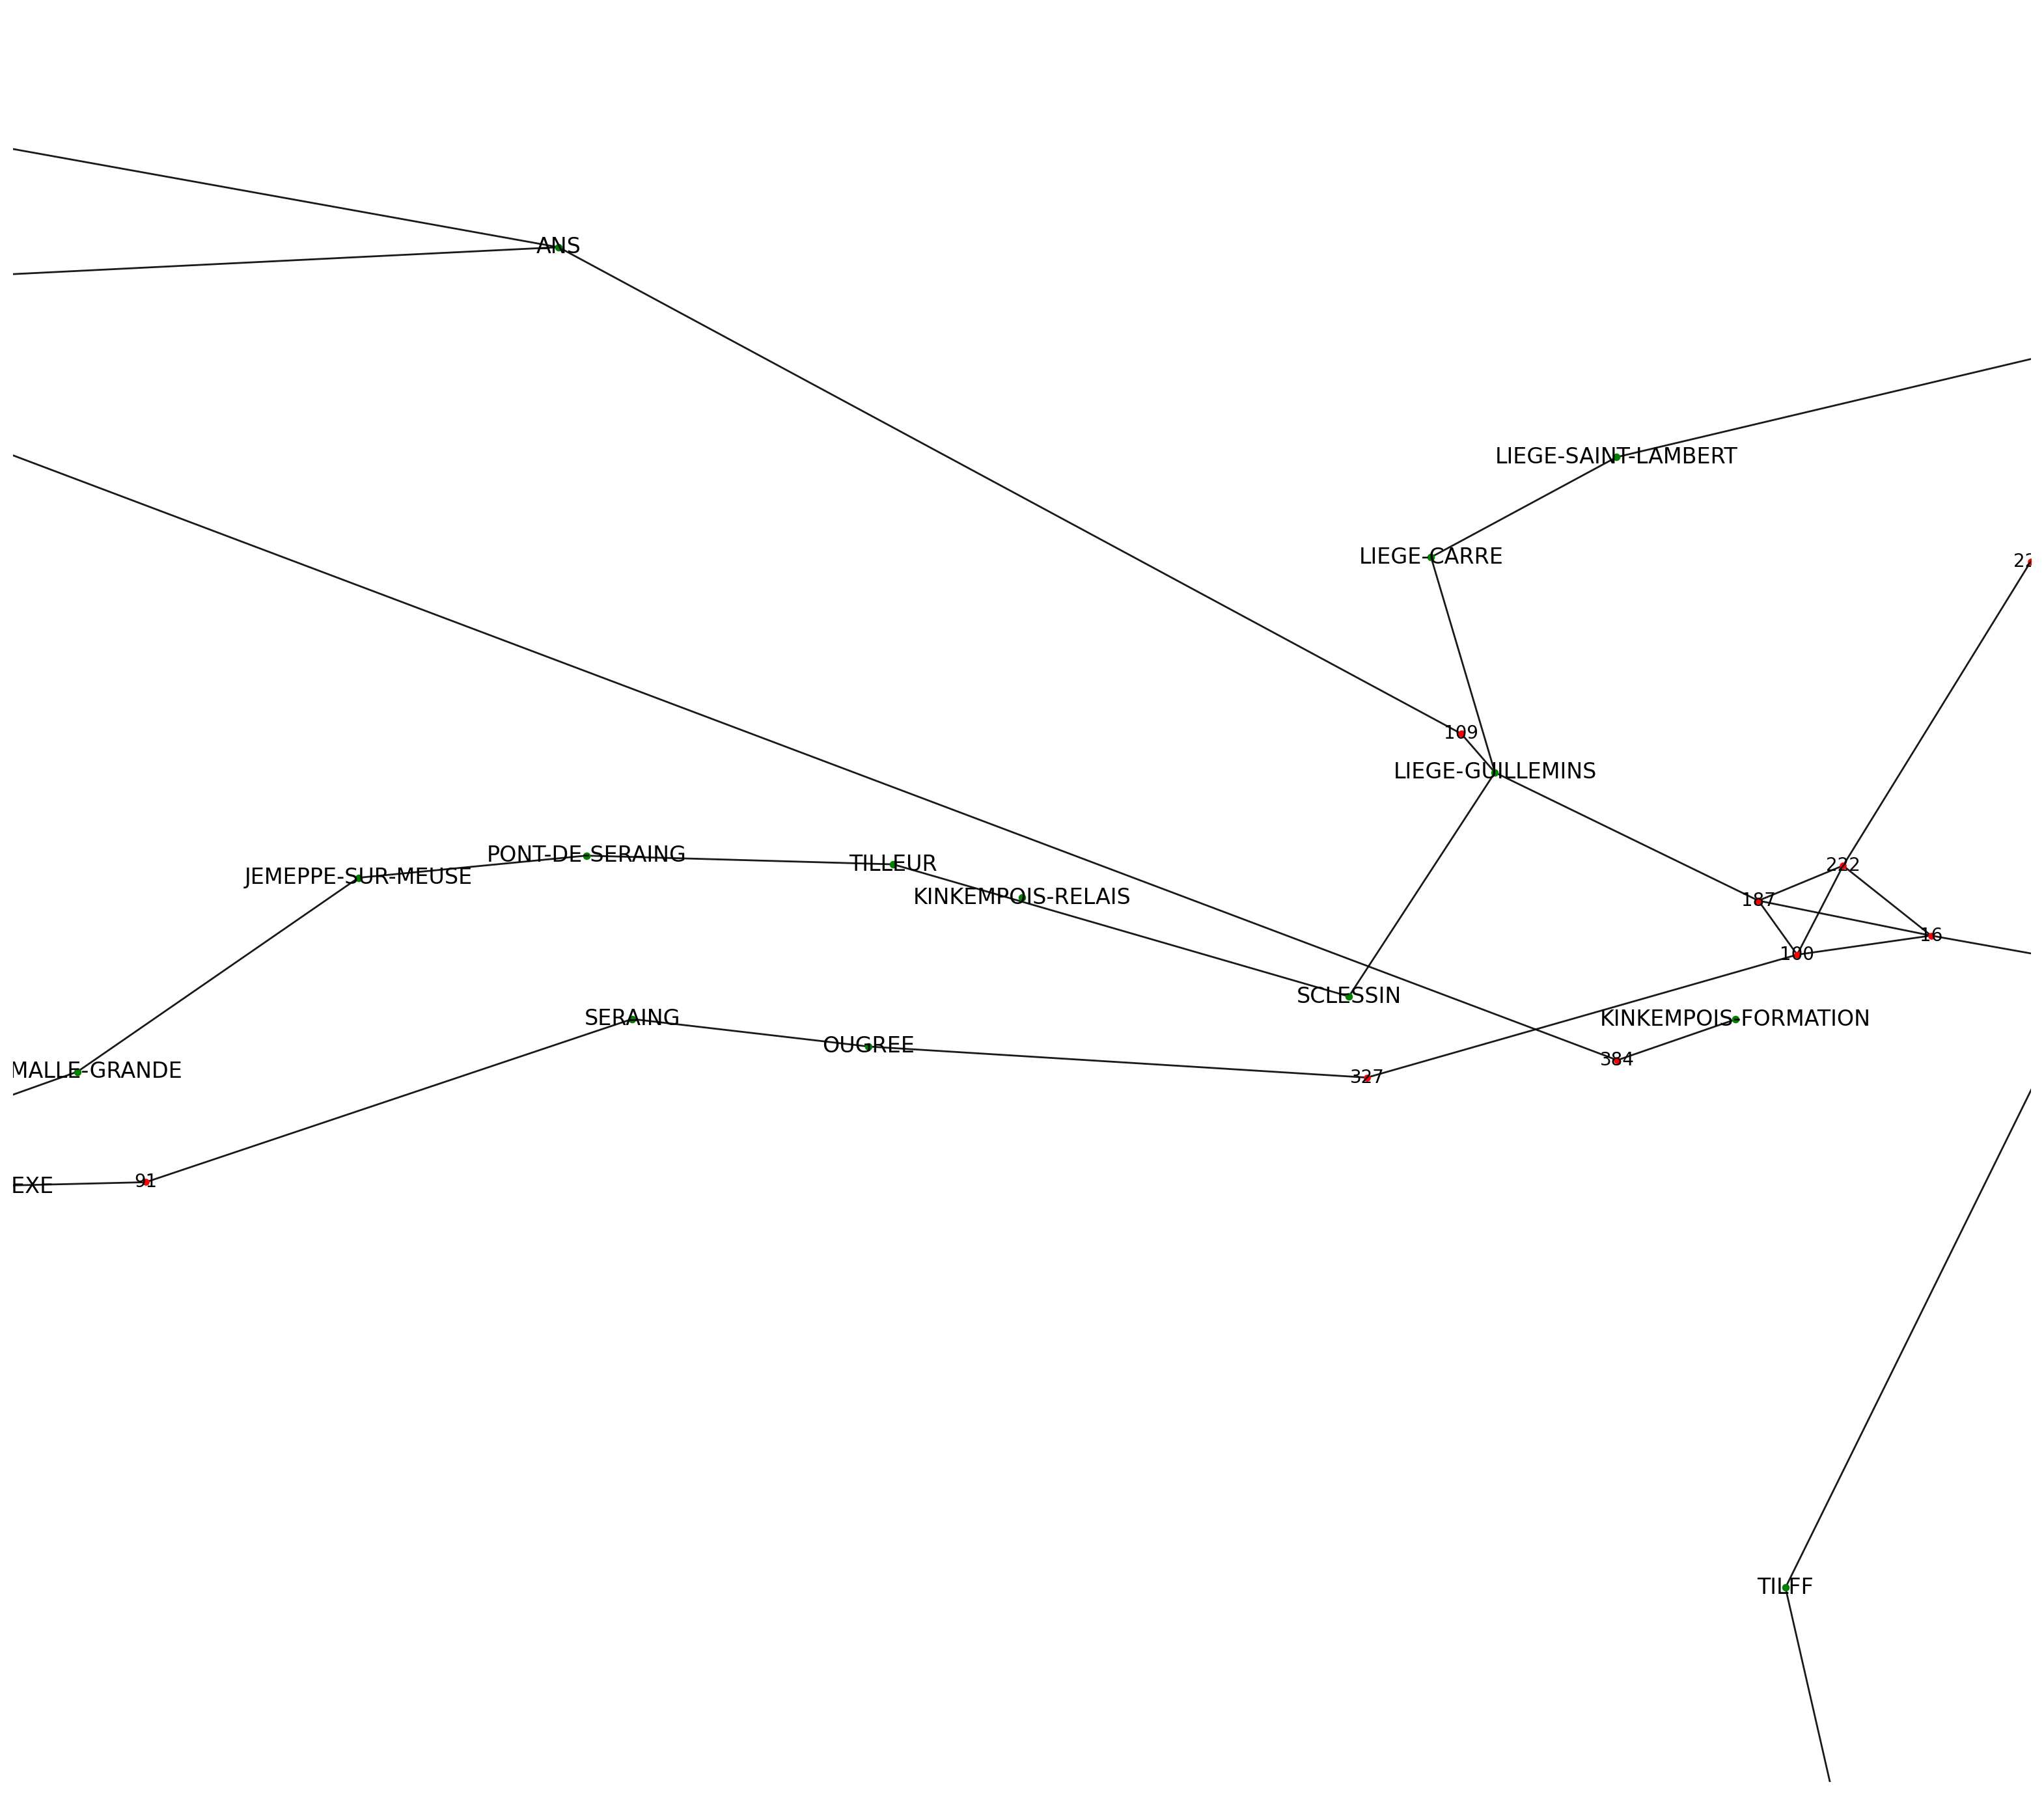

In [60]:
target_node="KINKEMPOIS-RELAIS"
NGpos =  {u: (dd["lon"], dd["lat"]) for u, dd in NG.nodes(data = True)}
X,Y = NGpos[target_node]

eps_left = 0.06
eps_right = 0.06
mx1, mx2 = X - eps_left, X + eps_right
my1, my2 = Y - eps_left, Y + eps_right

# ### extract geometry objects to plot 

np1 = (mx1, my1)
np2 = (mx1, my2)
np3 = (mx2, my2)
np4 = (mx2, my1)
bounding_box = Polygon([np1, np2, np3, np4])

bbox  = gp.GeoDataFrame(gp.GeoSeries(bounding_box), columns = ["geometry"])

segmentatie_to_plot_df = gp.overlay(segmentatie_geo_df, bbox, how = "intersection")

### extract end points to plot 
# end_points_to_plot = [(x,y) for (x,y) in end_points if mx1 <x<mx2 and my1 <y< my2 ]
# station_points_to_plot = [(x,y) for (x,y) in station_points if mx1 <x<mx2 and my1 <y< my2 ]
# station_names_to_plot = [name for name, (x,y) in zip(station_names, station_points) if mx1 <x<mx2 and my1 <y< my2]

### plot the figure
fig = plt.figure(figsize=(20,18), dpi = 200)
ax = plt.gca()

# segmentatie_geo_df.plot(ax = ax, lw = 1, color = "C0", alpha = 0.6)
# segmentatie_to_plot_df.plot(ax = ax, lw = 1, color = "C0", alpha = 0.6)

nx.draw(NG, NGpos, node_color='grey', node_size=1, width=1, alpha = 0.9)

non_stations = [u for u, dd in NG.nodes(data = True) if isinstance(u, int)]
stations = set(NG.nodes()) - set(non_stations)
nx.draw_networkx_nodes(NG, NGpos, non_stations, node_size = 8, alpha = 1, node_color = "red")
nx.draw_networkx_nodes(NG, NGpos, stations, node_size = 10, alpha = 1, node_color = "green")

all_node_labels= {}
# stations_node_labels = {}
junctions_node_labels = {}

for u in NG.nodes():
    if isinstance(u, int):
        junctions_node_labels[u] = u
        continue
    all_node_labels[u] = u

interesting_stations = {u:u for u in list(NG.neighbors(target_node))}
# for u in interesting_stations:
#     interesting_stations_dict[u] = u
    
nx.draw_networkx_labels(NG, NGpos, labels = all_node_labels, font_size = 12)
nx.draw_networkx_labels(NG, NGpos, labels = junctions_node_labels, font_size = 10)
# nx.draw_networkx_labels(NG, NGpos, labels = interesting_stations, font_size = 10)

plt.xlim([mx1, mx2])
plt.ylim([my1, my2])

plt.show()

# Test the network

# Upload data

#### Create list of files to upload data from

In [53]:
month = "11"
year = "2019"

base_in_dir = Path("./infrabel_data_json/")
data_dir = os.path.join(base_in_dir, "-".join([year, month]))
files_list = sorted(os.listdir(data_dir))
path_list = [os.path.join(data_dir, f) for f in files_list]
print(files_list)

['2019-11-01', '2019-11-02', '2019-11-03', '2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07', '2019-11-08', '2019-11-09', '2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30']


#### Upload data from list of files 

In [54]:
schedule_loaded = []
for f_index in tqdm(range(0,len(files_list))):
    upload_path = path_list[f_index]
    schedule_loaded.append((files_list[f_index], upload_schedule(upload_path)))

  0%|          | 0/30 [00:00<?, ?it/s]

### Test for compliance of the network with the train schedules

Go through all schedules, for each check out only stations that exist in the network, then go through consequtive pairs. If there is an edge between pair of stations, then we use it to store the train passages. If there is none, then we look for the shortest paths between these two nodes and check out those situations when there are multiple shortest paths.

In [57]:
NG.add_edge('LISSEWEGE', 'BRUGGE-SINT-PIETERS')

In [58]:
# TEST for compliance of the full network with the train schedules
train_G = deepcopy(NG)

forbidden_trains = ["EURST", "TGV", "THAL", "IZY", "INT", "EXTRA", "ICE", "CHARTER"]
multiple_shortest_paths = set([])
line_search_rows = []
pairs_not_in_network = set([])
count = 0
for day, day_schedule in tqdm(schedule_loaded[1:10]):
    in_schedule = defaultdict(list)
    for train, schedule in day_schedule.items():
        for row in schedule:
            if row[0] in train_G:
                in_schedule[train].append(row)

    for train, schedule in in_schedule.items():
        if any(s in train for s in forbidden_trains):
            continue
        first_time = True
        for row1, row2 in zip(schedule, schedule[1:]):
            previous_station = row1[0]
            current_station = row2[0]

            if previous_station in train_G and current_station in train_G:
                count += 1
                if train_G.has_edge(previous_station, current_station):
                    if "count_passage" in train_G[previous_station][current_station]:
                        train_G[previous_station][current_station]["count_passage"] += 1
                    else:
                        train_G[previous_station][current_station]["count_passage"] = 1
                else:
                    shortest_path = list(nx.all_shortest_paths(train_G, previous_station, current_station))
                    if len(shortest_path) > 1:
                        multiple_shortest_paths.add((previous_station, current_station))
print(f"Mutliple shortest paths {len(multiple_shortest_paths)}")

  0%|          | 0/9 [00:00<?, ?it/s]

NetworkXNoPath: Target KINKEMPOIS-RELAIS cannot be reachedfrom given sources

In [59]:
previous_station, current_station

('LIEGE-GUILLEMINS', 'KINKEMPOIS-RELAIS')

### Test for presence of nodes in the network

Check out all nodes that are present in the schedules, but not in the network. Best case - only intermediate stations, training, carwashes, extra perrons, etc. will be there. 

In [46]:
# TEST for presence of nodes in network
train_G = deepcopy(NG)

forbidden_trains = ["EURST", "TGV", "THAL", "IZY", "INT", "EXTRA", "ICE", "CHARTER"]
nodes_not_in_network = set([])
for day, day_schedule in tqdm(schedule_loaded[1:]):
    for train, schedule in day_schedule.items():
        if any(s in train for s in forbidden_trains):
            continue
        first_time = True
        for row in schedule:
            current_station = row[0]
            if current_station not in train_G:
                nodes_not_in_network.add(current_station)
print(f"Nodes not in network: {len(nodes_not_in_network)}")


Nodes not in network: 51


In [47]:
print(nodes_not_in_network)

{'LEUVEN-BUNDEL M', 'KORTENBERG-GOEDEREN', 'ANTWERPEN-KIEL', 'SCHAARBEEK-VORMING', 'MECHELEN', 'MOUSTIER-GARAGE', 'HAVERSIN-GARAGE', 'SCHULEN-SAS', 'HALLE-GOEDEREN', 'MARCHE-LES-DAMES-MARCHANDISES', 'SCHAARBEEK-D.O.P.', 'GENT-SINT-PIETERS-BUNDELS', 'KAPELLEN-WIJKSPOOR', 'GENTBRUGGE-PERRON C.W.', 'HASSELT-AFLOS L.35', 'RONET-FORMATION', 'HASSELT-AFWISSELING', 'SCHAARBEEK-PERRON P.C.I.', 'MARCINELLE', 'OOSTENDE-PERRON T.O.P.', 'SCHAARBEEK-GROEP G', 'OTTIGNIES-RELAIS', 'HAACHT-WIJKSPOOR', 'SCHAARBEEK-BUNDEL V', 'LOBBES-GARAGE', 'OBOURG-MARCHANDISES', 'RHISNES-SAS', 'HENNUYERES-GARAGE', 'SCHAARBEEK-GROEP R', 'GEDINNE-MARCHANDISES', 'CHATELET-CARWASH', 'CHATELET-FORMATION', 'LEUVEN-BUNDEL Q', 'ANTWERPEN-OOST', 'RIVAGE-MARCHANDISES', 'ZEEBRUGGE-STRAND', 'MUIZEN-GOEDEREN', 'TILLY-GARAGE', 'LUCHTBAL-WIJKBUNDEL', 'SCHAARBEEK-PERRON T.W./D.-NOS', 'SCHAARBEEK-PERRON VORMING', 'IZEGEM-SAS', 'BAULERS', 'BILZEN-WIJKSPOOR', 'ANTWERPEN-DAM', 'CHATELET-FAISCEAU C', 'CHARLEROI-FAISCEAU A', 'NEUFVILLES-G

# Create a simplified version of the network

Simplified version of the network is made to exclude the junctions. The full network is taken, for each pair of nodes we calculate the shortest path between them, and if it consists only of junctions (integer stations), we draw an edge in the simplified graph. Node set of the new graph is all str stations. 

In [85]:
NG_simple = nx.Graph()
for u, ud in tqdm(NG.nodes(data = True)):
    if isinstance(u, int):
        continue
    for v, vd in NG.nodes(data = True):
        if isinstance(v, int) or u == v:
            continue
        shortest_path = nx.shortest_path(NG, u, v)
        is_all_integers = True
        if len(shortest_path) > 2:
            previous_station = u
            for i in shortest_path[1:-1]:
                if not isinstance(i, int):
                    is_all_integers = False
                    break
                else:
                    previous_station = i

        if is_all_integers:
            NG_simple.add_node(u, lon= ud["lon"], lat = ud["lat"])
            NG_simple.add_node(v, lon= vd["lon"], lat = vd["lat"])
            NG_simple.add_edge(u,v)


### Manually remove extra edges

In [95]:
NG_simple.remove_edges_from([("ANTOING", "HALLE"), ("ANTOING", "SILLY"), ("MAUBRAY", "ATH"), 
                            ("MAUBRAY", "HALLE"), ("MAUBRAY", "SILLY"), ("SILLY", "HALLE"),
                            ('HALLE', "RUISBROEK"), ('HUIZINGEN',"RUISBROEK"),
                            ("CHENEE", "WELKENRAEDT"), ("WELKENRAEDT", "TONGEREN"), 
                            ("ANTWERPEN-LUCHTBAL", "NOORDERKEMPEN"),
                            ("HAREN", "HAREN-ZUID"), ('MONT-SAINT-GUIBERT', 'LOUVAIN-LA-NEUVE'),
                            ("WEERDE", "BRUSSELS AIRPORT - ZAVENTEM")])

vorst_zuid_error_neighbors = set(NG_simple.neighbors("VORST-ZUID")) - set(["RUISBROEK", "BRUSSEL-ZUID"])
for v in vorst_zuid_error_neighbors:
    NG_simple.remove_edge("VORST-ZUID", v)

brussel_zuid_error_neighbors = set(NG_simple.neighbors("BRUSSEL-ZUID")) - set(['GENT-SINT-PIETERS', 
                                                                               'VORST-OOST', 
                                                                               'VORST-ZUID',
                                                                              "BRUSSEL-KAPELLEKERK",
                                                                            "BRUSSEL-WEST"])
for v in brussel_zuid_error_neighbors:
    NG_simple.remove_edge("BRUSSEL-ZUID", v)
    
gent_error_neighbors = set(NG_simple.neighbors("GENT-SINT-PIETERS")) - set(['BRUSSEL-ZUID', 
                                                                               'DE PINTE', 
                                                                               'DRONGEN',
                                                                              "GENTBRUGGE",
                                                                              "MERELBEKE"])
for v in gent_error_neighbors:
    NG_simple.remove_edge("GENT-SINT-PIETERS", v)
    
NG_simple.add_edge("TROOZ", "CHENEE")

## Save the network

In [96]:
out_network_dir = "./final_network"
os.makedirs(out_network_dir, exist_ok = True)
simplified_network_path = os.path.join(
    out_network_dir,
    "network_Belgium_simplified.graphml"
)
nx.write_graphml(NG_simple, simplified_network_path)

## Test simplified network for multiple shortest paths

We apply the same procedure as above. We record pairs of stations in situations when there are multiple shortest paths between nodes.

In [89]:
train_G = deepcopy(NG_simple)

forbidden_trains = ["EURST", "TGV", "THAL", "IZY", "INT", "EXTRA", "ICE", "CHARTER"]
multiple_shortest_paths = set([])

for day, day_schedule in tqdm(schedule_loaded):
    in_schedule = defaultdict(list)
    for train, schedule in day_schedule.items():
        for row in schedule:
            if row[0] in train_G:
                in_schedule[train].append(row)
    
    for train, schedule in in_schedule.items():
        if any(s in train for s in forbidden_trains):
            continue
        first_time = True
        
        for row1, row2 in zip(schedule, schedule[1:]):
            previous_station = row1[0]
            current_station = row2[0]
            if previous_station in train_G and current_station in train_G:
                if train_G.has_edge(previous_station, current_station):
                    if "count_passage" in train_G[previous_station][current_station]:
                        train_G[previous_station][current_station]["count_passage"] += 1
                    else:
                        train_G[previous_station][current_station]["count_passage"] = 1
                else:
                    shortest_path = list(nx.all_shortest_paths(train_G, previous_station, current_station))
                    if len(shortest_path) > 1:
                        multiple_shortest_paths.add((previous_station, current_station))
print(f"Mutliple shortest paths {len(multiple_shortest_paths)}")


Mutliple shortest paths 15


In [55]:
print(multiple_shortest_paths)

{('VILVOORDE', 'BRUSSEL-NOORD'), ('SCHAARBEEK', 'EPPEGEM'), ('EPPEGEM', 'SCHAARBEEK'), ('MUIZEN', 'HOFSTADE'), ('HASSELT', 'LEUVEN'), ('KAPELLEN', 'ZAVENTEM'), ('KONTICH-LINT', 'MORTSEL'), ('BRUSSEL-LUXEMBURG', 'DELTA'), ('SCHAARBEEK', 'MECHELEN-NEKKERSPOEL'), ('SCHAARBEEK', 'VILVOORDE'), ('MECHELEN-NEKKERSPOEL', 'SCHAARBEEK'), ('MUIZEN', 'LEUVEN'), ('ZAVENTEM', 'SINT-MARIABURG'), ('MORTSEL-LIERSESTEENWEG', 'DUFFEL'), ('HOFSTADE', 'MUIZEN'), ('ANTWERPEN-NOORDERDOKKEN', 'KONTICH-LINT')}


## Test the passage counts through edges in the simplified network

In [56]:
train_G = deepcopy(NG_simple)

forbidden_trains = ["EURST", "TGV", "THAL", "IZY", "INT", "EXTRA", "ICE", "CHARTER"]
stations_passage = []
schedule_length_one = []

count_days = 0
for day, day_schedule in tqdm(schedule_loaded[:5]):
    count_days+= 1
    clean_day_schedule = defaultdict(list)
    for train, schedule in day_schedule.items():
        for row in schedule:
            if row[0] in train_G:
                clean_day_schedule[train].append(row)
                if "passage_count" in train_G.nodes[row[0]]:
                    train_G.nodes[row[0]]["passage_count"] += 1
                else:
                    train_G.nodes[row[0]]["passage_count"] = 1
    
    for train, schedule in clean_day_schedule.items():
        if any(s in train for s in forbidden_trains):
            continue
        if len(schedule) == 2: 
            schedule_length_one.append((train, schedule))
        for row1, row2 in zip(schedule, schedule[1:]):
            u, v = row1[0], row2[0]
            shortest_path = nx.shortest_path(train_G, u, v)
            if len(shortest_path) > 2:
                for w1,w2 in zip(shortest_path, shortest_path[1:]):
                    if "train_count" in train_G[w1][w2]:
                        train_G[w1][w2]["train_count"] += 1
                    else:
                        train_G[w1][w2]["train_count"] = 1
            elif len(shortest_path) == 2:
                if "train_count" in train_G[u][v]:
                    train_G[u][v]["train_count"] += 1
                else:
                    train_G[u][v]["train_count"] = 1
for e1,e2 in train_G.edges():
    if "train_count" in train_G[e1][e2]:
        train_G[e1][e2]["train_count"] /= count_days
for u in train_G.nodes():
    if "passage_count" in train_G.nodes[u]:
        train_G.nodes[u]["passage_count"] /= count_days

In [64]:
no_passage_count = []
passage_count_records = []
for u,d in train_G.nodes(data = True):
    if "passage_count" not in d:
        no_passage_count.append((u,d))
        continue
    else:
        passage_count_records.append((u, d["passage_count"]))
passage_count_records.sort(key = lambda x: x[-1])

In [68]:
not_train_count = []
train_count_records = []
for u,v,d in train_G.edges(data = True):
    if "train_count" not in d:
        not_train_count.append((u,v,d))
        continue
    else:
        train_count_records.append((u,v,d["train_count"]))
train_count_records.sort(key = lambda x: x[-1])


# Plot the network with the bounding box around a target node

In [3]:
out_network_dir = "./final_network"
simplified_network_path = os.path.join(
    out_network_dir,
    "network_Belgium_simplified.graphml"
)
NG_simple = nx.read_graphml(simplified_network_path)

In [4]:
NG_simplepos =  {u: (dd["lon"], dd["lat"]) for u, dd in NG_simple.nodes(data = True)}

/opt/conda/lib/python3.7/site-packages/geopandas/base.py:48: UserWarning: GeoSeries crs mismatch: epsg:4326 and None
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


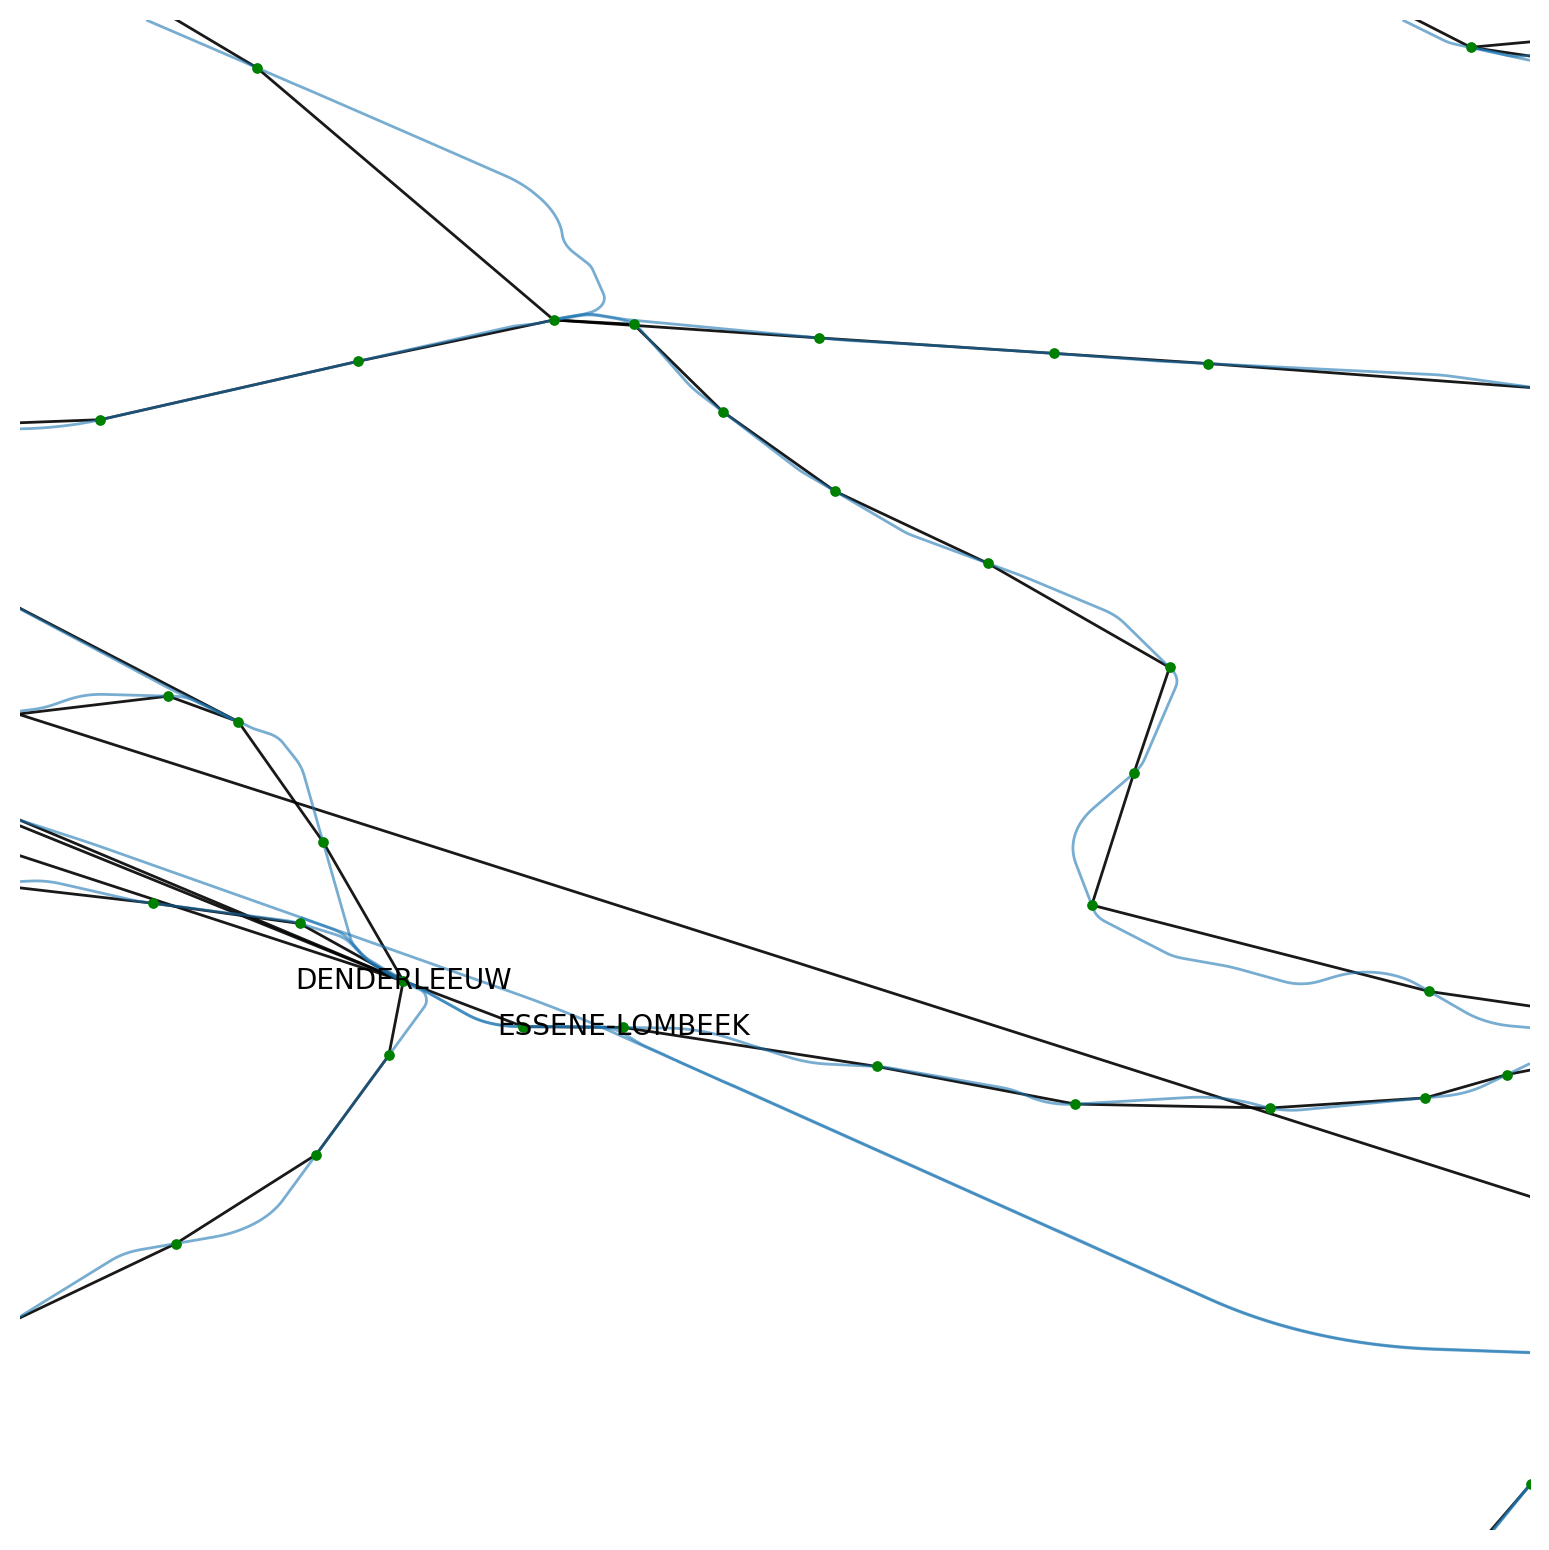

In [10]:
target_node = 'LIEDEKERKE'
X,Y = NG_simplepos[target_node]

eps_left = 0.1
eps_right = 0.2
eps_bottom, eps_top = 0.1, 0.2
mx1, mx2 = X - eps_left, X + eps_right
my1, my2 = Y - eps_bottom, Y + eps_top

# ### extract geometry objects to plot 

np1 = (mx1, my1)
np2 = (mx1, my2)
np3 = (mx2, my2)
np4 = (mx2, my1)
bounding_box = Polygon([np1, np2, np3, np4])

bbox  = gp.GeoDataFrame(gp.GeoSeries(bounding_box), columns = ["geometry"])

segmentatie_to_plot_df = gp.overlay(segmentatie_geo_df, bbox, how = "intersection")

### extract end points to plot 
# end_points_to_plot = [(x,y) for (x,y) in end_points if mx1 <x<mx2 and my1 <y< my2 ]
# station_points_to_plot = [(x,y) for (x,y) in station_points if mx1 <x<mx2 and my1 <y< my2 ]
# station_names_to_plot = [name for name, (x,y) in zip(station_names, station_points) if mx1 <x<mx2 and my1 <y< my2]

### plot the figure
fig = plt.figure(figsize=(12,10), dpi = 200)
ax = plt.gca()

# segmentatie_geo_df.plot(ax = ax, lw = 1, color = "C0", alpha = 0.6)
segmentatie_to_plot_df.plot(ax = ax, lw = 1, color = "C0", alpha = 0.6)


nx.draw(NG_simple, NG_simplepos, node_color='green', node_size=6, width=1, alpha = 0.9)

nx.draw_networkx_nodes(NG_simple, NG_simplepos, node_size = 8, alpha = 1, node_color = "green")

edge_to_draw = [(u,v) for u,v, d in NG_simple.edges(data = True) if "train_count" in d]
edge_width = [0.5*d["train_count"]**(0.3) for _,_, d in NG_simple.edges(data = True) if "train_count" in d]

# nx.draw_networkx_edges(NG_simple, NG_simplepos, edge_to_draw, width = edge_width, alpha = 0.5)

all_node_labels= {}

for u in NG_simple.nodes():
    all_node_labels[u] = u
    
interesting_stations = {u:u for u in list(NG_simple.neighbors(target_node))}
for u in NG_simple.neighbors(target_node):
    interesting_stations[u] = u
    
nx.draw_networkx_labels(NG_simple, NG_simplepos, labels = interesting_stations, font_size = 10)
# nx.draw_networkx_labels(NG_simple, NG_simplepos, labels = all_node_labels, font_size = 7)

plt.xlim([mx1, mx2])
plt.ylim([my1, my2])

plt.show()